In [9]:
import argparse
import json
import os
import time
import itertools
import pickle
import copy
import random
import math

import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset, TensorDataset
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
import dfca as DFCA
import ifca as IFCA

import numpy as np

from util import *

Reads Config file and prepares the arguments you can choose in the config_dfca.json/config_ifca.json

In [10]:
LR_DECAY = False
def get_dfca_config():

    # read config json and update the sysarg
    with open("config_dfca.json", "r") as read_file:
        config = json.load(read_file)

    if config["config_override"] == "":
        del config['config_override']
    else:
        print(config['config_override'])
        config_override = json.loads(config['config_override'])
        del config['config_override']
        config.update(config_override)

    return config

def get_ifca_config():

    # read config json and update the sysarg
    with open("config_ifca.json", "r") as read_file:
        config = json.load(read_file)

    if config["config_override"] == "":
        del config['config_override']
    else:
        print(config['config_override'])
        config_override = json.loads(config['config_override'])
        del config['config_override']
        config.update(config_override)

    return config

Running the dfca experiment

In [ ]:
start_time = time.time()
config = get_dfca_config()

config['train_seed'] = config['data_seed']

print("config:",config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

exp = DFCA.TrainMNISTCluster(config, device)
exp.setup()
dfca = exp.run()
duration = (time.time() - start_time)
print("---train cluster Ended in %0.2f hour (%.3f sec) " % (duration/float(3600), duration))


config: {'m': 1200, 'm_test': 200, 'p': 4, 'n': 200, 'uneven': True, 'h1': 200, 'num_epochs': 5, 'batch_size': 100, 'tau': 10, 'lr': 0.1, 'data_seed': 10, 'train_seed': 10, 'project_dir': 'output_dfca'}
Using device: cuda


Running the ifca experiment

In [ ]:
start_time = time.time()
config = get_ifca_config()

config['train_seed'] = config['data_seed']

print("config:",config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

exp = IFCA.TrainMNISTCluster(config, device)
exp.setup()
ifca = exp.run()
duration = (time.time() - start_time)
print("---train cluster Ended in %0.2f hour (%.3f sec) " % (duration/float(3600), duration))


config: {'m': 1200, 'm_test': 200, 'p': 4, 'n': 200, 'uneven': True, 'h1': 200, 'num_epochs': 5, 'batch_size': 100, 'tau': 10, 'lr': 0.1, 'data_seed': 10, 'train_seed': 10, 'project_dir': 'output_ifca'}
Using device: cuda
Epoch -1 tr: l 2.294 a 0.113 clct[346, 317, 154, 383] cl_acc 0.562  1.693sec
Epoch -1 tst: l 2.292 a 0.114 clct[53, 69, 22, 56] cl_acc 0.575  0.252sec
Epoch 0 tr: l 2.170 a 0.391 clct[304, 413, 175, 308] cl_acc 0.873  lr 0.100000 6.164sec(train) 2.560sec(infer)
Epoch 0 tst: l 2.168 a 0.394 clct[49, 73, 25, 53] cl_acc 0.850  0.353sec
result written at output_ifca\results.pickle
checkpoint written at output_ifca\checkpoint.pt
Epoch 1 tr: l 1.909 a 0.643 clct[302, 297, 301, 300] cl_acc 0.997  lr 0.100000 7.578sec(train) 1.651sec(infer)
Epoch 1 tst: l 1.905 a 0.650 clct[50, 51, 49, 50] cl_acc 0.995  0.254sec
Epoch 2 tr: l 1.566 a 0.737 clct[300, 300, 300, 300] cl_acc 1.000  lr 0.100000 50.481sec(train) 1.591sec(infer)
Epoch 2 tst: l 1.559 a 0.747 clct[50, 50, 50, 50] cl_a

Experiment Final Results: 

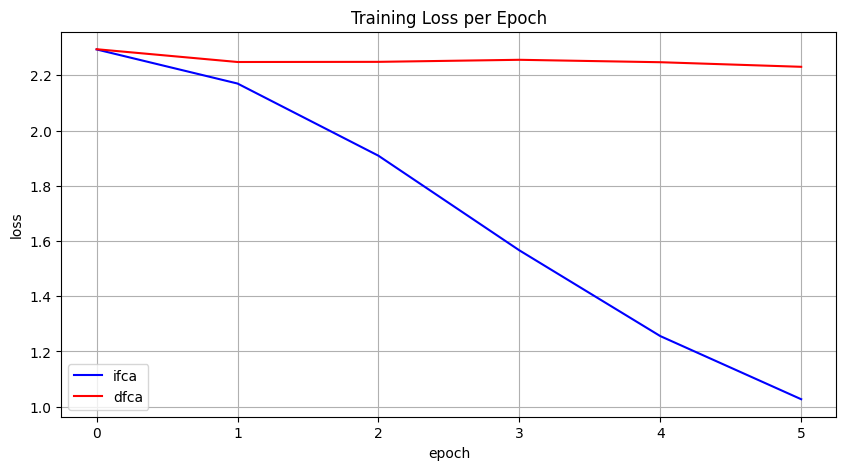

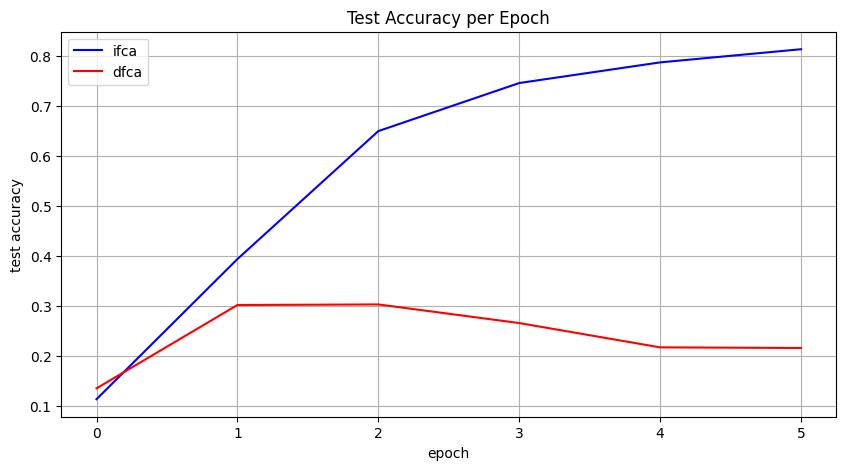

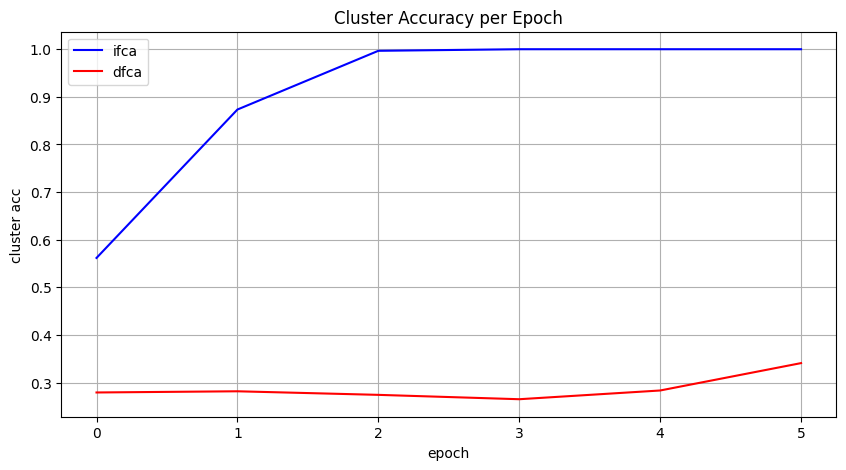

In [ ]:
os.makedirs('graphs', exist_ok=True)

plt.figure(figsize=(10,5))
plt.plot([r['train']['loss'] for r in ifca], label='ifca', color='blue')
plt.plot([r['train']['loss'] for r in dfca], label='dfca', color='red')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join('graphs', 'train_loss.png'))

plt.figure(figsize=(10,5))
plt.plot([r['test']['acc'] for r in ifca], label='ifca', color='blue')
plt.plot([r['test']['acc'] for r in dfca], label='dfca', color='red')
plt.xlabel('epoch')
plt.ylabel('test accuracy')
plt.title('Test Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join('graphs', 'test_acc.png'))

plt.figure(figsize=(10,5))
plt.plot([r['train']['cl_acc'] for r in ifca[:31]], label='ifca', color='blue')
plt.plot([r['train']['cl_acc'] for r in dfca[:31]], label='dfca', color='red')
plt.xlabel('epoch')
plt.ylabel('cluster acc')
plt.title('Cluster Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join('graphs', 'cluster_acc.png'))